In [1]:
import matplotlib.pyplot as plt
import graphviz
from graphviz import Graph
import networkx as nx

In [2]:
import numpy as np
import pandas as pd
import joblib
import pickle
import lightgbm as lgb
import catboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool,cv
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

Загружаем собранный датасет для обработки и анализа. Источники данных:
- https://otrude.net/employers/32100
- https://neorabote.net/feedback/list/company/37548
- https://orabote.biz/feedback/list/company/37548

In [3]:
data = pd.read_csv("raw_data.csv")
data.head()

,Отрасль,Компания,Дата отзыва,Должность,Город,Статус,Лет,Плюсы,Минусы,Лайки,Дизлайки,Оплата труда,Начальство,Рабочее место,Коллектив,Карьерный рост
0,Разработка ПО,2ГИС,2017-10-21,Менеджер по продажам,Ярославль,да,<1,Хорошо врут на собеседовании в городе Ярославл...,"Перестать писать на superjob или hh о том, то ...",41.0,8.0,2.0,1.0,3.0,1.0,1.0
1,Разработка ПО,2ГИС,2016-09-23,Менеджер по продажам,Екатеринбург,да,1-2,Официальное трудоустройство. Если реально рабо...,"В целом минусы те, которые просто есть в любой...",12.0,1.0,4.0,3.0,5.0,5.0,4.0
2,Разработка ПО,2ГИС,2017-05-01,Менеджер по продажам,Оренбург,да,<1,"Работаю в Оренбурге! Нравится, что за тобой ни...","Постоянно в разъездах по городу, делать приход...",14.0,5.0,4.0,4.0,5.0,5.0,3.0
3,Разработка ПО,2ГИС,2017-08-08,Менеджер по продажам,Каменск-Уральский,да,1-2,Основным плюсом работы в данной компании являе...,Со стороны работодателя созданы все условия дл...,18.0,9.0,4.0,5.0,5.0,5.0,3.0
4,Разработка ПО,2ГИС,2016-10-19,Инженер,Киевское,нет,<1,Можно повстречать новых друзей и знакомых кото...,"Научиться не ""пудрить людям мозги"", ну и банал...",22.0,6.0,2.0,2.0,4.0,4.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 16 columns):
Отрасль           2139 non-null object
Компания          2139 non-null object
Дата отзыва       2139 non-null object
Должность         2139 non-null object
Город             1881 non-null object
Статус            2139 non-null object
Лет               2038 non-null object
Плюсы             2139 non-null object
Минусы            2139 non-null object
Лайки             2138 non-null float64
Дизлайки          2138 non-null float64
Оплата труда      2068 non-null float64
Начальство        2067 non-null float64
Рабочее место     2067 non-null float64
Коллектив         2068 non-null float64
Карьерный рост    2068 non-null float64
dtypes: float64(7), object(9)
memory usage: 267.5+ KB


## Очистка и подготовка данных

In [5]:
data['Дата отзыва'] = pd.to_datetime(data['Дата отзыва'])
data['year'] = 2000 - data['Дата отзыва'].dt.year
data[['Лайки', 'Дизлайки', 'Оплата труда', 'Начальство', 'Рабочее место', 'Коллектив', \
      'Карьерный рост']] = data[['Лайки', 'Дизлайки', 'Оплата труда', 'Начальство', 'Рабочее место', \
                                 'Коллектив', 'Карьерный рост']].fillna(0).astype('int8')

In [6]:
data['Отрасль'].value_counts(dropna=False, normalize=True)

Пищевая промышленность         0.171576
Услуги                         0.169238
Энергетика и энергоносители    0.152408
Связь                          0.148200
Государственные организации    0.114072
Финансовые услуги              0.086489
Розница                        0.058906
Разработка ПО                  0.046751
ИТ консалтинг                  0.029453
Строительство                  0.022908
Name: Отрасль, dtype: float64

In [7]:
data['Компания'].value_counts(dropna=False, normalize=True)

Пятерочка                     0.171576
Почта России                  0.115007
РЖД                           0.088359
МТС                           0.083216
Ростелеком                    0.064984
Kari                          0.058906
Роснефть                      0.054231
Гринатом                      0.045816
Сибур                         0.035063
Деловые линии                 0.034128
ТрансНефть                    0.031791
Сбербанк                      0.029453
Первый БИТ                    0.023843
СтройГазКонсалтинг            0.022908
МФЦ                           0.020570
Домодедово                    0.020103
Газпром Нефть                 0.017765
Яндекс                        0.013558
2ГИС                          0.012155
Контур                        0.008415
Трасса                        0.006545
КРОК                          0.005610
СбербанкТехнологии            0.005610
Моё дело                      0.004675
Финам                         0.003740
Росатом                  

In [8]:
#ohe без необходимости объединения
data['Энергетика'] = np.where(data['Отрасль'] == 'Энергетика и энергоносители', 1, 0)
data['Финансы'] = np.where(data['Отрасль'] == 'Финансовые услуги', 1, 0)
data['ИТ консалтинг'] = np.where(data['Отрасль'] == 'ИТ консалтинг', 1, 0)
data['Связь'] = np.where(data['Отрасль'] == 'Связь', 1, 0)
data['Пищевая'] = np.where(data['Отрасль'] == 'Пищевая промышленность', 1, 0)
data['Разработка ПО'] = np.where(data['Отрасль'] == 'Разработка ПО', 1, 0)
data['Розница'] = np.where(data['Отрасль'] == 'Розница', 1, 0)
#можно не удалять ['Отрасль'], просто не включать в список фич

In [9]:
data['Пятерочка'] = np.where(data['Компания'] == 'Пятерочка', 1, 0)
data['Почта'] = np.where(data['Компания'] == 'Почта России', 1, 0)
data['РЖД'] = np.where(data['Компания'] == 'РЖД', 1, 0)
data['МТС'] = np.where(data['Компания'] == 'МТС', 1, 0)
data['Ростелеком'] = np.where(data['Компания'] == 'Ростелеком', 1, 0)
data['Kari'] = np.where(data['Компания'] == 'Kari', 1, 0)
data['Роснефть'] = np.where(data['Компания'] == 'Роснефть', 1, 0)
data['Гринатом'] = np.where(data['Компания'] == 'Гринатом', 1, 0)
data['Сибур'] = np.where(data['Компания'] == 'Сибур', 1, 0)
data['ДеловыеЛинии'] = np.where(data['Компания'] == 'Деловые линии', 1, 0)
data['ТрансНефть'] = np.where(data['Компания'] == 'ТрансНефть', 1, 0)
data['Сбербанк'] = np.where(data['Компания'] == 'Сбербанк', 1, 0)
data['ПервыйБИТ'] = np.where(data['Компания'] == 'Первый БИТ', 1, 0)
data['СтройГазКонс'] = np.where(data['Компания'] == 'СтройГазКонсалтинг', 1, 0)
data['МФЦ'] = np.where(data['Компания'] == 'МФЦ', 1, 0)
data['Аэропорт'] = np.where(data['Компания'] == 'Домодедово', 1, 0)
data['ГазпромНефть'] = np.where(data['Компания'] == 'Газпром Нефть', 1, 0)
data['Яндекс'] = np.where(data['Компания'] == 'Яндекс', 1, 0)
data['2ГИС'] = np.where(data['Компания'] == '2ГИС', 1, 0)
data['Контур'] = np.where(data['Компания'] == 'Контур', 1, 0)
data['Трасса'] = np.where(data['Компания'] == 'Трасса', 1, 0)
data['КРОК'] = np.where(data['Компания'] == 'КРОК', 1, 0)
data['СбербанкТех'] = np.where(data['Компания'] == 'СбербанкТехнологии', 1, 0)
data['МоёДело'] = np.where(data['Компания'] == 'Моё дело', 1, 0)
data['Финам'] = np.where(data['Компания'] == 'Финам', 1, 0)
data['Росатом'] = np.where(data['Компания'] == 'Росатом', 1, 0)
data['Касперского'] = np.where(data['Компания'] == 'Лаборатория Касперского', 1, 0)
data['Межрегионтест'] = np.where(data['Компания'] == 'Межрегионтест', 1, 0)
data['Метрополитен'] = np.where(data['Компания'] == 'Петербергский метрополитен', 1, 0)
data['МэйлРу'] = np.where(data['Компания'] == 'МэйлРу', 1, 0)
data['Профи'] = np.where(data['Компания'] == 'Профи', 1, 0)
data['Консультант+'] = np.where(data['Компания'] == 'Консультант плюс', 1, 0)
data['МОЭК'] = np.where(data['Компания'] == 'МОЭК', 1, 0)
data['НефтьМагистраль'] = np.where(data['Компания'] == 'НефтьМагистраль', 1, 0)
data['Гута'] = np.where(data['Компания'] == 'Гута', 1, 0)

- Бухгалтер - работа с финансовой документацией 
- Инженер - работа с технической документацией (в т.ч. технологи, сметчики)  
- Офисный сотрудник - работа с планово-аналитической документацией (экономисты, аналитики, специалисты)
- Руководитель - руководство другими людьми 
- ИТ-специалист - разработка и внедрение ПО  
- Обслуживающий персонал - охранники, дворники, электрики, водители  
- Рабочие - основной производственный персонал (операторы, аппаратчики, слесари)  
- Продавцы - непосредственно осуществляют акты купли-продажи  
- Консультанты - работа с людьми напрамую
- Оператор call-центра - работа с людьми по телефону (операторы колл-центров, техподдержки и т.д)

In [10]:
#Схлопываем множество должностей в 10 основных
buh_list = ['Бухгалтер', 'бухгалтер', 'Старший бухгалтер', 'бухгалтер вна', 
            'старший бухгалтер','ведущий бухгалтер', 'Операционист', 
            'Ведущий бухгалтер','Главный бухгалтер', 'Казначей',]
ingen_list = ['Инженер', 'Ведущий инженер', 'Старший инженер', 'Инженер-проектировщик', 
              'Технолог', 'Сметчик', 'Технолог производства', 'Инженер-технолог', 
              'Инженер-лаборант', 'Инженер-химик', 'Лаборант','Инженер по охране труда', 
              'Инженер связи', 'Инженер электросвязи', 'Инженер-электрик',
              'Инженер-энергетик', 'Главный инженер', 'ИТР', 'Инженер-метролог', 
              'Инженер-механик','Научный сотрудник','Техник','Технический специалист',]
ofis_list = ['Аналитик', 'Ведущий экономист', 'Экономист', 'Маркетолог', 
             'Руководитель проекта', 'Менеджер проекта','Офис-менеджер', 'Помощник', 
             'Асессор', 'Юрисконсульт', 'Менеджер по закупкам','Юрист','Логист',
             'специалист отдела маркетинга', 'специалист по документообороту', 
             'Контент-менеджер', 'Медиапланер','Специалист кадрового администрирования', 
             'Рекрутер', 'Системный аналитик','Оператор ввода данных', 'Трейдер', 
             'Менеджер проектов', 'HR-manager', 'Инспектор', 'Кадровик','Координатор',
             'Кризис-менеджер','Руководитель проектов', 'Делопроизводитель','Документовед', 
             'Менеджер по сертификации','Ревизор','HR-менеджер', 'Менеджер ГСО','Методист',
             'Инспектор безопасности', 'Контролер','Контролер склада',]
meneg_list = ['Старший смены', 'Руководитель', 'Директор магазина', 'Директор', 
              'Менеджер среднего звена','Исполнительный директор','Начальник','Управляющая', 
              'Начальник управления КДП','Руководитель направления',  'Директор салона', 
              'Заместитель директора', 'Заместитель директора магазина', 
              'Заместитель начальника', 'Руководитель группы','Руководитель офиса', 
              'Начальник группы', 'Начальник офиса продаж', 'Заместитель руководителя',
              'Начальник отдела', 'Начальник поезда', 'Начальник службы', 'Начальник смены', 
              'Начальник участка','Заместитель начальника отдела', 'Начальник ОПС','АУП',]
it_list = ['Программист', 'IT-специалист', 'Системный инженер', 'Разработчик', 'ИТ', 
           'ИТ специалист','сетевой инженер', 'Front-end developer', 'Тестировщик', 
           'Модератор', 'Системный администратор', 'Ведущий разработчик', 
           'Java-разработчик','Ведущий специалист по внедрению', 'Внедренец',
           'Главный разработчик','Инсталлятор', 'Программист 1С', 'Программист C++', 
           'Senior developer','Инженер-программист',]
obsl_list = ['Водитель', 'Дворник', 'Электромонтер', 'Электромеханик', 'Электромонтажник', 
             'Охранник', 'Грузчик','Уборщица',  'Курьер', 'Тренер','Спасатель', 
             'Водитель погрузчика', 'Водитель-экспедитор',]
work_list = ['Аппаратчик', 'Слесарь', 'Оператор товарный', 'Машинист', 'Горнорабочий', 
             'Оператор ДНГ','Слесарь-ремонтник',  'Плотник', 'Отделочник', 
             'Комплектовщик', 'Сварщик', 'Кабельщик','Кабельщик-спайщик','Монтажник',
             'Мастер по обслуживанию абонентов', 'Мастер','Оператор склада',
             'Сервисный инженер', 'Бригадир', 'Газосварщик', 'ДСП', 'Дежурный по переезду', 
             'Дежурный по станции','Дефектоскопист', 'Дорожный рабочий', 
             'Инспектор по входному контролю', 'Инспектор по досмотру','Инструктор', 
             'Кладовщик', 'Котельщик', 'Маляр','Машинист крана', 'Машинист электровоза',
             'Медицинский представитель', 'Механик', 'Монтер', 'Монтер пути', 
             'Помощник машиниста', 'Докер','Приемосдатчик','Проводник','Санитарка',
             'Слесарь КИПиА','Слесарь-сантехник','Станочник','Старший оператор','Электрик',
             'Электрослесарь', 'Автослесарь', 'Почтальон', 'Сортировщик','Элекросврщик', 
             'Стропальщик', 'Оператор самоходных механизмов','Разнорабочий',]
trade_list = ['Продавец','Менеджер по продажам', 'Продавец-кассир', 'Оператор-кассир', 
              'Кассир-оператор','Агент','Оператор','Кассир торгового зала','Оператор АЗС', 
              'Оператор заправочной станции', 'Заправщик', 'Оперотор','Заправщик АЗС',
              'Продавец-консультант', 'грузчик. продавец-консультант', 'Мерчандайзер',
              'Продавец-универсал','Менеджер активных продаж',  'Кассир', 'Гастрономист',
              'Специалист ОПП', 'Супервайзер','Телемаркетолог', 'Товаровед', 
              'Торговый представитель', 'Работник торгового зала','Парт-таймер',
              'Старший кассир','Оператор связи', ]
cons_list = ['Консультант', 'Менеджер', 'Менеджер по работе с клиентами', 
             'Менеджер по обслуживанию','Специалист микрофинансовых операций', 
             'Финансовый консультант', 'КБП', 'Менеджер кредитования','Кредитный эксперт', 
             'Эксперт', 'Персональный менеджер', 'Менеджер по сопровождению',
             'Администратор','Специалист', 'Ведущий специалист', 'Старший специалист', 
             'Младший специалист', 'Главный специалист','Оператор информационной базы',
             'Агент регистрации',]
op_list = ['Оператор техподдержки', 'Оператор колл-центра', 'Helpdesk', 
           'инженер технической поддержки', 'Инженер техподдержки', 'Диспетчер', 
           'Специалист call-центра', 'Оператор технической поддержки',
           'Консультант технической поддержки', 'Агент СФТО', 'Специалист колл-центра',]

In [11]:
set(data['Должность']) - set(buh_list) - set(ingen_list) - set(ofis_list) - set(meneg_list) - set(it_list) - \
    set(obsl_list) - set(work_list) -set(trade_list) - set(cons_list) - set(op_list)

{'Должность не указана'}

In [12]:
data['Бухгалтер'] = np.where(data['Должность'].isin(buh_list), 1, 0)
data['Инженер'] = np.where(data['Должность'].isin(ingen_list), 1, 0)
data['Офисный сотрудник'] = np.where(data['Должность'].isin(ofis_list), 1, 0)
data['Руководитель'] = np.where(data['Должность'].isin(meneg_list), 1, 0)
data['ИТ'] = np.where(data['Должность'].isin(it_list), 1, 0)
data['Обслуживающий персонал'] = np.where(data['Должность'].isin(obsl_list), 1, 0)
data['Рабочий'] = np.where(data['Должность'].isin(work_list), 1, 0)
data['Продавец'] = np.where(data['Должность'].isin(trade_list), 1, 0)
data['Консультант'] = np.where(data['Должность'].isin(cons_list), 1, 0)
data['Оператор call-центра'] = np.where(data['Должность'].isin(op_list), 1, 0)
data['Без должности'] = np.where(data['Должность'] == 'Должность не указана', 1, 0).astype('int8')

In [13]:
data['Город'] = data['Город'].fillna('Не указан')
data['Город'].value_counts(dropna=False).head(10)

Москва             410
Не указан          258
Санкт-Петербург    135
Нижний Новгород    112
Екатеринбург        52
Самара              49
Ростов-на-Дону      39
Новосибирск         37
Краснодар           36
Домодедово          36
Name: Город, dtype: int64

In [14]:
#data['Город'] = le.fit_transform(data['Город']).astype('int8')
town_list = ['Москва', 'Нижний Новгород', 'Не указан',]
#'Тобольск', 'Самара', 'Краснодар', 'Нижневартовск', 'Екатеринбург'
data['Москва'] = np.where(data['Город'] == 'Москва', 1, 0).astype('int8')
data['Нижний Новгород'] = np.where(data['Город'] == 'Нижний Новгород', 1, 0).astype('int8')
data['Санкт-Петербург'] = np.where(data['Город'] == 'Санкт-Петербург', 1, 0).astype('int8')
#data['Тобольск'] = np.where(data['Город'] == 'Тобольск', 1, 0).astype('int8')
#data['Самара'] = np.where(data['Город'] == 'Самара', 1, 0).astype('int8')
#data['Краснодар'] = np.where(data['Город'] == 'Краснодар', 1, 0).astype('int8')
#data['Нижневартовск'] = np.where(data['Город'] == 'Нижневартовск', 1, 0).astype('int8')
#data['Екатеринбург'] = np.where(data['Город'] == 'Екатеринбург', 1, 0).astype('int8')
data['Не указан'] = np.where(data['Город'] == 'Не указан', 1, 0).astype('int8')
data['Прочие'] = np.where(data['Город'].isin(town_list), 0, 1)

In [15]:
data['Статус'].value_counts(dropna=False, normalize=True)

нет           0.517999
да            0.452080
соискатель    0.029921
Name: Статус, dtype: float64

In [16]:
#нет - уволился, да = работает
data['Статус'] = data['Статус'].map({'нет': -1, 'да': 1, 'соискатель': 0,}).astype('int8')

In [17]:
data['Лет'].value_counts(dropna=False, normalize=True)

<1      0.363254
1-2     0.234222
3-5     0.180458
>10     0.093034
5-10    0.081814
NaN     0.047218
Name: Лет, dtype: float64

In [18]:
data['Лет'] = data['Лет'].map({'>10': 5, '5-10': 4, '3-5': 3, '1-2': 2, '<1': 1,}).fillna(0).astype('int8')

In [19]:
data['Count_plus'] = data['Плюсы'].str.count(" ") + 1
data['Count_minus'] = data['Минусы'].str.count(" ") + 1

In [20]:
#цель уволившиеся
data['target'] = np.where(data['Статус'] == -1, 1, 0).astype('int8')
#без соискателей
data = data.loc[data['Статус'] != 0]
data['target'] = np.where(data['Статус'] == -1, 1, 0).astype('int8')
data['target'].value_counts(dropna=False) 

1    1108
0     967
Name: target, dtype: int64

In [21]:
#Объединим отзыв в одно текстовое поле
data['Отзыв'] = data['Плюсы'] + ' ' + data['Минусы']
#data.head()

## Анализ связи фич

In [22]:
corr1 = data.corrwith(data['target']).reset_index()
corr1.columns = ['Index','Correlations']
corr1 = corr1.set_index('Index')
corr1.sort_values(by=['Correlations'], ascending = False).iloc[1:]

,Correlations
Index,
Count_minus,0.146082
Разработка ПО,0.132171
МТС,0.123603
ПервыйБИТ,0.109754
Консультант,0.103335
...,...
Коллектив,-0.146604
Начальство,-0.148589
РЖД,-0.154187


Мы видим, что выбранная выборка очень смещена в сторону деловольных работников. Важен город, компания и должность работника. Также важно в каком году был сделан отзыв.

## Обучение модели

In [23]:
data.columns

Index(['Отрасль', 'Компания', 'Дата отзыва', 'Должность', 'Город', 'Статус',
       'Лет', 'Плюсы', 'Минусы', 'Лайки', 'Дизлайки', 'Оплата труда',
       'Начальство', 'Рабочее место', 'Коллектив', 'Карьерный рост', 'year',
       'Энергетика', 'Финансы', 'ИТ консалтинг', 'Связь', 'Пищевая',
       'Разработка ПО', 'Розница', 'Пятерочка', 'Почта', 'РЖД', 'МТС',
       'Ростелеком', 'Kari', 'Роснефть', 'Гринатом', 'Сибур', 'ДеловыеЛинии',
       'ТрансНефть', 'Сбербанк', 'ПервыйБИТ', 'СтройГазКонс', 'МФЦ',
       'Аэропорт', 'ГазпромНефть', 'Яндекс', '2ГИС', 'Контур', 'Трасса',
       'КРОК', 'СбербанкТех', 'МоёДело', 'Финам', 'Росатом', 'Касперского',
       'Межрегионтест', 'Метрополитен', 'МэйлРу', 'Профи', 'Консультант+',
       'МОЭК', 'НефтьМагистраль', 'Гута', 'Бухгалтер', 'Инженер',
       'Офисный сотрудник', 'Руководитель', 'ИТ', 'Обслуживающий персонал',
       'Рабочий', 'Продавец', 'Консультант', 'Оператор call-центра',
       'Без должности', 'Москва', 'Нижний Новгород', '

In [24]:
features =['Лет', 'Оплата труда', 'Начальство', 'Рабочее место', 'Коллектив', 
           'Карьерный рост','Бухгалтер','Инженер', 'Офисный сотрудник','Руководитель', 
           'Обслуживающий персонал', 'Рабочий', 'Продавец', 'Консультант', 
           'Оператор call-центра', 'year', 'Count_plus', 'Count_minus',] 

In [25]:
#Стоп слова
stop = ['не', 'на', 'что', 'за', 'по', 'все', 'как', 'это', 'то', 'но', 'только', 'так', 
        'для', 'если', 'очень','из', 'от', 'ты', 'бы', 'вы', 'или', 'меня', 'еще', 'их', 
        'же', 'мне', 'до', 'да', 'без', 'при', 'там', 'уже', 'они', 'кто', 'когда', 
        'здесь', 'будет', 'всех', 'чем', 'со', 'всегда', 'сейчас', 'вас', 'где', 
        'быть', 'во', 'чтобы', 'мы', 'тоже', 'хотя', 'надо',]

In [26]:
#Выделяем фичи из текста
tfidf = TfidfVectorizer(min_df=3, ngram_range=(1, 3),  max_features=2500, stop_words=stop) # stop_words=stop
tfidf.fit(data['Отзыв'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=2500,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['не', 'на', 'что', 'за', 'по', 'все', 'как', 'это',
                            'то', 'но', 'только', 'так', 'для', 'если', 'очень',
                            'из', 'от', 'ты', 'бы', 'вы', 'или', 'меня', 'еще',
                            'их', 'же', 'мне', 'до', 'да', 'без', 'при', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [27]:
#Сохранение результатов TfidfVectorizer
joblib.dump(tfidf, 'tfidf.pkl') 

# load your model
#tfidf = joblib.load('tfidf.pkl') 

['tfidf.pkl']

In [28]:
#Трансформация тренировочных данных
X_sparse = tfidf.transform(data['Отзыв'])
X_sparse.shape, data[features].shape

((2075, 2500), (2075, 18))

In [29]:
#Объединение всех фич
X_hstack = csr_matrix(hstack([data[features], X_sparse]))

In [30]:
#Делим все на трейн и тест, валидационную выборку чтобы проверить результаты обучения. 
#Хотя деление такого маленького датасета ухудшит результат
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data['target'].values, 
                                                    test_size=0.25, 
                                                    shuffle=True, random_state=99)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                random_state=77)

In [31]:
%%time
#catboost
params = {'loss_function' : 'Logloss', 'eval_metric' : 'AUC', 'logging_level' : 'Silent', 
          'colsample_bylevel' : 0.5, 'leaf_estimation_iterations': 2, 'depth':6, 
         }

trn_data = Pool(X_train_part, label=y_train_part)
val_data = Pool(X_valid, label=y_valid)

cat_clf = CatBoostClassifier(**params) 
cat_clf.fit(trn_data, eval_set=val_data, early_stopping_rounds=100, verbose_eval=100) 
#Прогноз
cat_predict = cat_clf.predict(X_test, prediction_type='Probability')[:, 1]

0:	test: 0.6148520	best: 0.6148520 (0)	total: 53.4ms	remaining: 53.3s
100:	test: 0.7325149	best: 0.7325149 (100)	total: 317ms	remaining: 2.83s
200:	test: 0.7380952	best: 0.7383846 (157)	total: 577ms	remaining: 2.29s
300:	test: 0.7396247	best: 0.7408647 (274)	total: 835ms	remaining: 1.94s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7408647487
bestIteration = 274

Shrink model to first 275 iterations.
CPU times: user 2.83 s, sys: 675 ms, total: 3.5 s
Wall time: 1.19 s


In [32]:
roc_auc = roc_auc_score(y_test, cat_predict)
print("ROC AUC:    {:.4f}".format(roc_auc))

ROC AUC:    0.6746


In [33]:
#Сохранение модели CatBoostClassifier
cat_clf.save_model('cat_clf.cbm')
#cat_clf = CatBoostClassifier() #task_type='GPU'
#cat_clf.load_model('cat_clf.cbm')

In [34]:
#lgb 
params =  {'objective' : 'binary', 'metric' : 'auc', 'boosting_type' : 'gbdt', 
           'subsample_freq' : 3,  'subsample' : 0.9, 'colsample_bytree' : 0.5, 
           'num_leaves': 6,
         }
    
train_data = lgb.Dataset(X_train_part, label=y_train_part)
valid_data = lgb.Dataset(X_valid, label=y_valid)
        
lgb_clf = lgb.train(params, train_data, num_boost_round=100, valid_sets = [train_data, valid_data], 
                    verbose_eval=500, early_stopping_rounds = 50) #categorical_feature = cat_features, 
    
lgb_predict = lgb_clf.predict(X_test, num_iteration=lgb_clf.best_iteration) 

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.814697	valid_1's auc: 0.725033


In [35]:
roc_auc = roc_auc_score(y_test, lgb_predict)
print("ROC AUC:    {:.4f}".format(roc_auc))

ROC AUC:    0.6595


In [36]:
#Сохранение модели lgb.Booster
lgb_clf.save_model('lgb_clf.txt', num_iteration=lgb_clf.best_iteration)
#lgb_clf = lgb.Booster(model_file = 'lgb_clf.txt')

In [37]:
# Альтернативный вариант
#joblib.dump(lgb_clf, 'lgb_clf.pkl')
# load model
#lgb_clf = joblib.load('lgb_clf.pkl')

## Графы

In [38]:
#Построение графа по сотрудникам Гринатома
data_gr_at = data.loc[data['Компания'] == 'Гринатом'].copy()

In [39]:
data_gr_at.shape

(81, 79)

In [40]:
data_gr_at["uid"] = range(1, 82)

In [41]:
#data_gr_at.head()

In [42]:
#заменим некорректно написаныне должности
data_gr_at['Должность'] = data_gr_at['Должность'].str.replace('инженер технической поддержки','Helpdesk').str.replace('Старший бухгалтер','Бухгалтер').str.replace('бухгалтер вна','Бухгалтер').str.replace('ведущий бухгалтер','Бухгалтер').str.replace('старший бухгалтер','Бухгалтер').str.replace('бухгалтер','Бухгалтер').str.replace('Ведущий экономист','Специалист').str.replace('Специалист кадрового администрирования','Специалист').str.replace('Старший инженер','Инженер').str.replace('сетевой инженер','Инженер')

In [43]:
#set(data_gr_at['Должность'])
data_gr_at['Должность'].value_counts(dropna=False, normalize=False)

Должность не указана    54
Бухгалтер               20
Специалист               3
Инженер                  2
Helpdesk                 2
Name: Должность, dtype: int64

In [44]:
#set(data_gr_at['Лет'])
data_gr_at['Лет'].value_counts(dropna=False, normalize=False)

2    31
1    27
3    17
4     5
5     1
Name: Лет, dtype: int64

In [45]:
#связи по количеству отработанных лет
year_1 = list(data_gr_at['uid'].loc[data_gr_at['Лет'] == 1])
year_2 = list(data_gr_at['uid'].loc[data_gr_at['Лет'] == 2])
year_3 = list(data_gr_at['uid'].loc[data_gr_at['Лет'] == 3])
year_4 = list(data_gr_at['uid'].loc[data_gr_at['Лет'] == 4])
year_5 = list(data_gr_at['uid'].loc[data_gr_at['Лет'] == 5])

link_1 = [(year_1[i], year_1[j]) for i in range(len(year_1)) for j in range(i+1, len(year_1))]
link_2 = [(year_2[i], year_2[j]) for i in range(len(year_2)) for j in range(i+1, len(year_2))]
link_3 = [(year_3[i], year_3[j]) for i in range(len(year_3)) for j in range(i+1, len(year_3))]
link_4 = [(year_4[i], year_4[j]) for i in range(len(year_4)) for j in range(i+1, len(year_4))]
link_5 = [(year_5[i], year_5[j]) for i in range(len(year_5)) for j in range(i+1, len(year_5))]

link = link_1 + link_2 + link_3 + link_4

In [46]:
#связи по полжностям
dol_1 = list(data_gr_at['uid'].loc[data_gr_at['Должность'] == 'Должность не указана'])
dol_2 = list(data_gr_at['uid'].loc[data_gr_at['Должность'] == 'Бухгалтер'])
dol_3 = list(data_gr_at['uid'].loc[data_gr_at['Должность'] == 'Специалист'])
dol_4 = list(data_gr_at['uid'].loc[data_gr_at['Должность'] == 'Инженер'])
dol_5 = list(data_gr_at['uid'].loc[data_gr_at['Должность'] == 'Helpdesk'])

link_d1 = [(dol_1[i], dol_1[j]) for i in range(len(dol_1)) for j in range(i+1, len(dol_1))]
link_d2 = [(dol_2[i], dol_2[j]) for i in range(len(dol_2)) for j in range(i+1, len(dol_2))]
link_d3 = [(dol_3[i], dol_3[j]) for i in range(len(dol_3)) for j in range(i+1, len(dol_3))]
link_d4 = [(dol_4[i], dol_4[j]) for i in range(len(dol_4)) for j in range(i+1, len(dol_4))]
link_d5 = [(dol_5[i], dol_5[j]) for i in range(len(dol_5)) for j in range(i+1, len(dol_5))]

link_d = link_d1 + link_d2 + link_d3 + link_d4

## Построение графа

In [47]:
G = nx.Graph()
G.add_nodes_from(list(data_gr_at['uid']))
G.add_edges_from(link)  
G.add_edges_from(link_d)  

In [48]:
len(link), len(link_d)

(962, 1625)

In [49]:
#Для раскрашивания
values = data_gr_at['Статус']
l = ['r'] * 962
d = ['b'] * 1625
colors = l + d

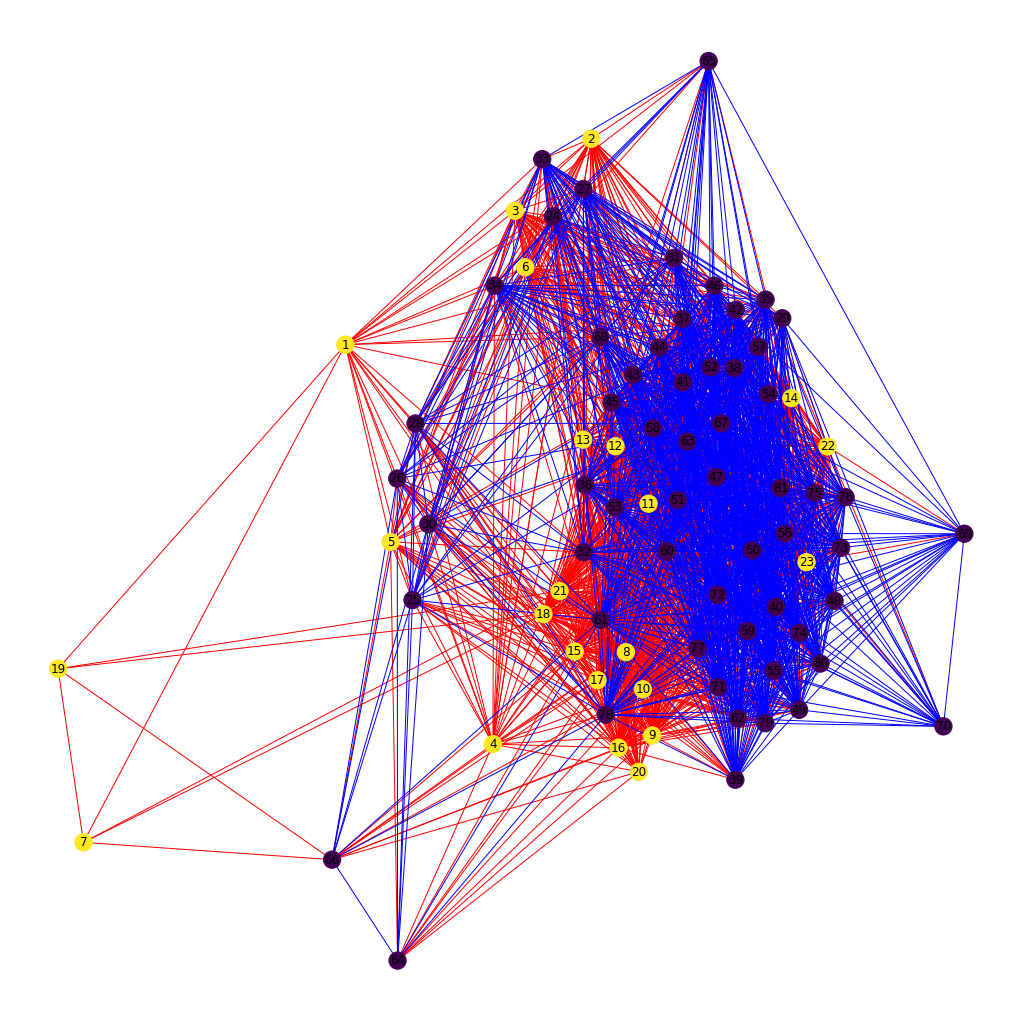

In [50]:
#желтые работают, коричневые уволились
#красные связи по годам работы, синие по должностям
plt.figure(figsize=(14, 14))
nx.draw(G, with_labels=True, node_color=values, edge_color = colors, width = 1) #font_weight='bold',

Дальше идет дополнительный анализ, не имеющий отношения к решению

## Облако слов

In [51]:
data_gr_at['Отзыв'].head()

64    В любой фирме есть плюсы, есть минусы. На мой ...
65    Белая з/плата, ДМС, стабильная хорошо оплачива...
66    Соцпаке, официальна заработна плата. Хороший к...
67    Будущих сотрудников филиала в г.Н.Новгород ЗАО...
68    Хочу выразить благодарность начальнику отдела ...
Name: Отзыв, dtype: object

In [52]:
data_gr_at_out = data_gr_at.loc[data_gr_at['target'] == 1].copy()
data_gr_at_in = data_gr_at.loc[data_gr_at['target'] == 0].copy()

In [53]:
data_gr_at_out.shape, data_gr_at_in.shape

((58, 80), (23, 80))

In [55]:
import os
import requests
from operator import attrgetter
from pathlib import Path
import nltk
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt
def read_stopwords(path='./stopwords-ru.txt', encoding='utf-8'):
    stopwords_en = stopwords.words('english')
    with open(path, encoding=encoding) as f:
        stopwords_ru = f.read().split('\n')
    return set(stopwords_ru) | set(stopwords_en)


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens


def plot_word_cloud(text, picture_fn='out.png', stopwords=None,
                    normalize=True, regexp=r'(?u)\b\w{4,}\b', **wc_kwargs):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    wc = WordCloud(**wc_kwargs).generate(' '.join(words))
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(picture_fn)

def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')
        
stopwords_ru = read_stopwords('stopwords-ru.txt')

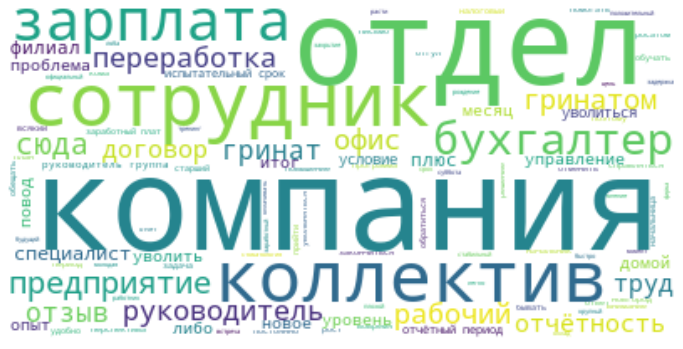

In [57]:
#Работающие (Гринатом)
text = data_gr_at_in['Отзыв'].str.cat(sep=' ')
plot_word_cloud(text, 'work.png', stopwords=stopwords_ru, max_words=100,
                background_color='white', normalize=True)

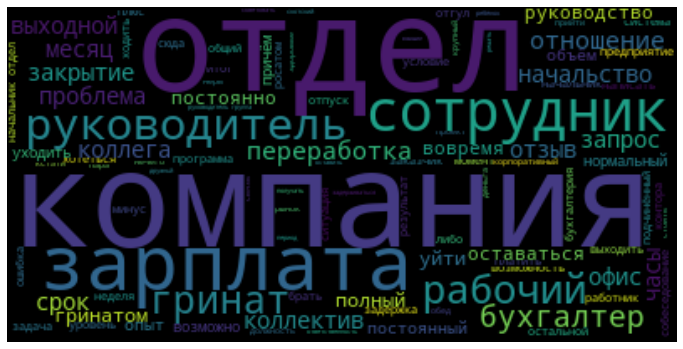

In [58]:
#Уволившиеся (Гринатом)
text = data_gr_at_out['Отзыв'].str.cat(sep=' ')
plot_word_cloud(text, 'out.png', stopwords=stopwords_ru, max_words=100,
                background_color='black', normalize=True)

In [59]:
data_out = data.loc[data['target'] == 1].copy()
data_in = data.loc[data['target'] == 0].copy()

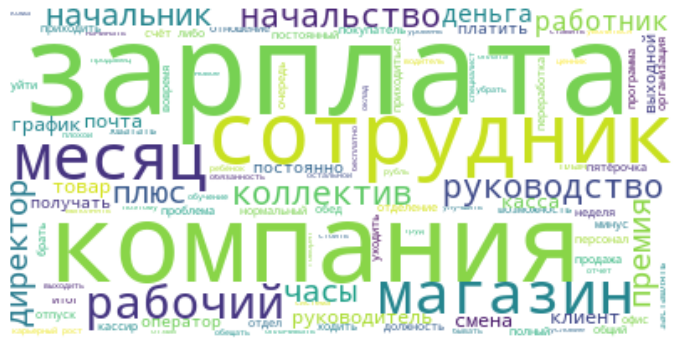

In [60]:
#Работающие (Полный датасейт)
text = data_in['Отзыв'].str.cat(sep=' ')
plot_word_cloud(text, 'ponedelnik_norm.png', stopwords=stopwords_ru, max_words=100,
                background_color='white', normalize=True)

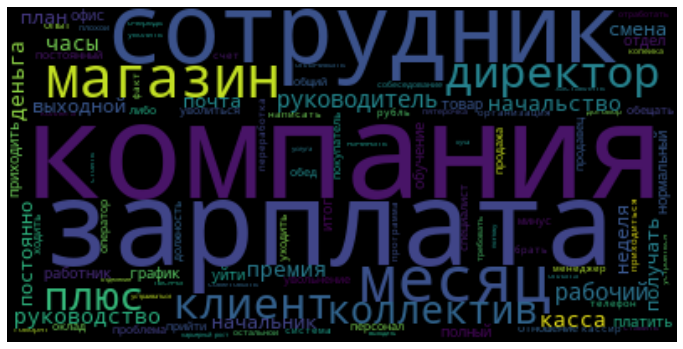

In [61]:
#Уволившиеся (Полный датасейт)
text = data_out['Отзыв'].str.cat(sep=' ')
plot_word_cloud(text, 'ponedelnik_norm.png', stopwords=stopwords_ru, max_words=100,
                background_color='black', normalize=True)